# Case WGG Digital Solutions

# 1 Problema de negócios

O case técnico apresentado pela WGG Digital Solutions envolve uma base de dados que contém informações críticas para a tomada de decisão em um contexto empresarial. Os dados, registrados em um arquivo Excel denominado 'Forecast Value', incluem percentuais de atingimento de metas de venda, organizados por país e distribuídos ao longo de um período de tempo específico, de fevereiro de 2022 a dezembro de 2023.

Cada registro na base de dados representa o percentual de uma meta de vendas alcançada por um país em um determinado mês. Por exemplo, um registro pode indicar que a meta para a Colômbia e o Equador em fevereiro de 2022 foi de 58%.

O problema de negócio a ser resolvido envolve a previsão do percentual de atingimento de metas para janeiro de 2024, com base nos dados históricos disponíveis. A capacidade de prever esse valor é importante para o planejamento estratégico, alocação de recursos e definição de metas futuras, permitindo que a empresa tome decisões proativas para otimizar suas operações e alcançar seus objetivos de vendas.

Este desafio requer a aplicação de técnicas de análise de dados e modelagem preditiva para fornecer uma estimativa precisa, auxiliando a empresa a antecipar tendências de desempenho e a agir de forma eficaz no mercado.

## Instalando as Bibliotecas necessarias

In [1]:
pip install summarytools

## Importando as Bibliotecas

In [2]:
import pandas as pd
from summarytools import dfSummary
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

## 2 Extraindo e entendendo melhor os dados.

Após extrairmos os dados, vamos analisar os dados contidos na planilha.

In [3]:
df = pd.read_excel('/content/Forecast Value (3) (1).xlsx')
df.head()

,Month/Year,Value,Country
0,2022-02-01,0.58,Colombia/Ecuador
1,2022-03-04,0.61,Colombia/Ecuador
2,2022-04-04,0.65,Colombia/Ecuador
3,2022-05-05,0.39,Colombia/Ecuador
4,2022-06-05,0.53,Colombia/Ecuador


In [4]:
dfSummary(df)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,Month/Year[datetime64[ns]],Min: 2022-02-01Max: 2023-12-08Duration: 675 days,23 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABNCAYAAACxBha+AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACWUlEQVR4nO3dPY7aUBSG4XPtAZkf2UIo0NGkjJTCJYvIYrOEFKyAIs1UdEgIGeGMhTFOlS4D+AIf4+R9Wri2j+8rEIWFq+vaAIXg2ReA/wexQebl3IvOuZ6ZdT2Oe6jr+s3vknRumM+sJTP6esTevxubc643Ho+/xXE8anq23W63dc59/8ibcct8Zu2Y0dej9v7cJ1s3juPRfD5/S5KkuPZkWZZFi8VitNlsumb2kTfCaz6zVs3o6yF7f/Zr1MwsSZJiMpn8anixvYbvfxrP+cxaNKOve+89PxAgQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZC4+8OKjqqqOmcXOuaZLAzM7eZzSZ118Op06Hucys9bM6LvupnvznrvHlud5pyzLr7PZLAzD8OrHwKqq6uR5/nk4HL4GQVA+el1ZllFVVV+KovhhZo2eIGrLjM+4N+fcPbbD4fASRVE/TdNiOp1ur123Wq1Gy+XyU5qmP4Xr+sfjMbx2zR8tm1F6b855yNeomdlgMGj0zOF2u+09Y90t2jLjM+7N3/ADATLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBDbJAhNsgQG2SIDTLEBhligwyxQYbYIENskCE2yBAbZIgNMsQGGWKDDLFBhtggQ2yQITbIEBtkiA0yxAYZYoMMsUGG2CBz8V/5siyLmhxwv99HZmZ5nkfr9br/r61r07Wq111q5TcRcXHeI7eXrAAAAABJRU5ErkJggg=="">",0(0.0%)
2,Value[float64],Mean (sd) : 0.7 (0.1)min < med < max:0.3 < 0.7 < 0.8IQR (CV) : 0.1 (6.7),29 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACkUlEQVR4nO3dQYriQBSA4VejNlEhQQTdeYGBWbj0EHPYOcIsPIE3cCdIiJjpYEwyq9n1qKlKkXrx//bVhs6PGFLFM03TCBC6b31fAPCKcd8XgG4ZY6Yi8mG5/NY0zWeX19MVQh0QY8x0uVz+jON4YbP+crmkxphfIcZKqMPyEcfxYrfbfSZJUrRZmGVZtN/vF+fz+UNECBX+JUlSrFarPxZLp51fTEd4mIIKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSpwZiowjsed47quJ7afXVXVRERiY4ztn/B23JpQA+J63Lksy6iqqu9FUfwWkVaH+/I8n5Rl+WOz2YxGo1GrE6z/+DxuTahhsT7uLCJyPB4Xh8Nhdr/fR23X3m63cRRFs+12W6zX67Ttet/HrQk1QLbHndM0dT7uPJ/PbY9ai3g8bs3DFFQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgXf9Hjhs1XPapjdkhNoxl616Ltv0ho5Qu2e9Vc9lm97QEaonNlv1utimN1Q8TEEFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCoQKFQgVKrAp5T/YUxoWQv0Ce0rDQ6hfY09pYAj1AfaUhoOHKahAqFCBUKGC19+ojhM+RBymbPQ5XeRdOU5VeXivvYXqOuFDxH7KRp/TRd6V61SVZ/fa5zeq04QPxykbvU0XeVcuU1VeuddPQ3V9Q5MkSdrXlI0+p4u8K4epKg//5w9D5Q0NQvHsG5U3NAiC9zdTeZ5Hp9Np1nZdlmVRVVVjsXuKjOu6HmdZFrVdKCJyvV4jEbtr72ut5s9+5T79BfTxbTtzdLoJAAAAAElFTkSuQmCC"">",0(0.0%)
3,Country[object],1. Colombia/Ecuador2. Peru3. Brasil,23 (33.3%)23 (33.3%)23 (33.3%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjcuMSwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy/bCgiHAAAACXBIWXMAAA9hAAAPYQGoP6dpAAABZUlEQVR4nO3bQWrCYBSF0ZcSSp0kBMHFuIgutovIbkT8B23pJB10aGeV+4s9ZwVP+FAiucO2bQUJT70P4P8YqmpXVc+9D7mhr23bPnofwbVxv9+/TtO09D7kVlpr52EY3gR3f8Zpmpbj8fgxz/Nn72P+6nK5vKzrupxOp+eqEtudGauq5nn+PBwO772PuZFd7wP4nQcEYsRGjNiIERsxYiNGbMSIjRixESM2YsRGjNiIERsxYiNGbMSMVT/vgfU+5BYe5XM8qrG1dl7XdakHeQ+stXauqq/ed3DNBoGYwZSPFN9sxFhXEWNdRYx1FTH+1CVGbMSIjRixESM2YsRGjNiIERsxYiNGbMSIjRixESM2YsRGjHUVMdZVxNggEGNdRYwHBGL8jBJjykeMKR8xpnzEeEAgRmzEiI0YsREjNmLERozYiBEbMWIjRmzEiI0YsREjNmLERowpHzGmfMTYIBBjykfMN77xo0reSBZ8AAAAAElFTkSuQmCC"">",0(0.0%)


## Data dictionary planilha *Forecast Value*

**Month/Year**: Coluna que contém a data, representada pelo ano, mês e dia, no formato YYYY-MM-DD. Esta coluna é usada para identificar o período ao qual o valor de venda está associado.

**Value**: Coluna que contém os valores percentuais de metas de vendas atingidas, expressos como números decimais (float). Por exemplo, um valor de 0.58 indica que 58% da meta de vendas foi alcançada.

**Country**: Coluna que identifica o país ao qual os dados de vendas correspondem. Esta coluna armazena o nome do país como uma string.

## Definindo as Variáveis Numéricas e Categóricas

Identificar e categorizar as variáveis numéricas e categóricas em nossos dados é essencial para revelar os padrões, tendências e insights escondidos. Essas classificações são fundamentais para aplicarmos as técnicas de análise corretas e extrairmos o máximo de informação possível dos dados.

Variáveis Numéricas:

 * Representam dados quantitativos que podem ser medidos e ordenados. No nosso contexto, a variável Value é numérica, pois ela expressa a porcentagem de metas de vendas atingidas em valores decimais. A análise dessa variável nos permitirá entender a variação do desempenho ao longo do tempo, calcular médias, desvio padrão, entre outros.

Variáveis Categóricas:

 * Representam dados qualitativos que são divididos em diferentes categorias ou grupos. As variáveis Month/Year e Country são categóricas:
 * Month/Year: Embora represente datas, nesta análise pode ser tratado como categórico para fins de agrupamento por períodos específicos, como meses ou anos.
 * Country: Como indica o nome do país, é uma variável categórica que nos ajuda a segmentar os dados e comparar o desempenho das metas de vendas entre diferentes países.

Ao distinguir claramente entre essas variáveis, podemos escolher os métodos estatísticos e de modelagem mais apropriados, conduzindo uma análise mais precisa e relevante que apoiará a tomada de decisões estratégicas.

In [5]:
features_numericas = df.select_dtypes('number').columns.tolist()
categorical_features = df.select_dtypes('object').columns.tolist()
data_features = df.select_dtypes('datetime').columns.tolist()

print(f'Contem {len(data_features)}. características de Data. Eles são: ')
print(data_features)

print(f'Contem {len(categorical_features)}. características categóricas. Eles são: ')
print(categorical_features)

print(f'Contem {len(features_numericas)} características numéricas. Eles são: ')
print(features_numericas)

Contem 1. características de Data. Eles são: 
['Month/Year']
Contem 1. características categóricas. Eles são: 
['Country']
Contem 1 características numéricas. Eles são: 
['Value']


## Outliers

Vou analisar os outliers nos dados para verificar se eles representam informações inconsistentes, como erros de medição. Após essa análise, decidirei se será necessário tratá-los ou não.

In [6]:
def check_outliers(data, features, iqr_multiplier=1.5, remove_outliers=False):
    """
    Função para verificar e remover outliers em um conjunto de dados.

    Parâmetros:
    - data: DataFrame contendo os dados.
    - features: Lista de colunas para verificar outliers.
    - iqr_multiplier: Constante para multiplicar o IQR (default=1.5).
    - remove_outliers: Se True, retorna o DataFrame sem os outliers.

    Retornos:
    - outlier_indexes: Dicionário com os índices dos outliers por feature.
    - outlier_counts: Dicionário com a contagem de outliers por feature.
    - total_outliers: Número total de outliers encontrados.
    - data (opcional): DataFrame sem os outliers (se remove_outliers=True).
    """

    outlier_indexes = {}
    outlier_counts = {}
    total_outliers = 0

    for feature in features:
        # Verificação de valores nulos
        if data[feature].isnull().sum() > 0:
            print(f"Atenção: A feature '{feature}' contém valores nulos.")

        Q1 = data[feature].quantile(0.25)
        Q3 = data[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
        outlier_indexes[feature] = outliers.index.tolist()
        outlier_counts[feature] = len(outliers)
        total_outliers += len(outliers)

        if remove_outliers:
            data = data.drop(outliers.index)

    if total_outliers == 0:
        print("Nenhum outlier foi encontrado.")

    if remove_outliers:
        return outlier_indexes, outlier_counts, total_outliers, data

    return outlier_indexes, outlier_counts, total_outliers


outlier_analysis_features = ['Value']

outlier_indexes, outlier_counts, total_outliers, df_clean = check_outliers(
    data=df,
    features=outlier_analysis_features,
    iqr_multiplier=1.5,
    remove_outliers=True
)

print(f"Outlier Indexes: {outlier_indexes}")
print(f"Outlier Counts: {outlier_counts}")
print(f"Total Outliers: {total_outliers}")

Outlier Indexes: {'Value': [3, 23, 24]}
Outlier Counts: {'Value': 3}
Total Outliers: 3


## Exploratory Data Analysis

Para obter uma compreensão mais profunda dos dados e identificar padrões, tendências e possíveis anomalias, é fundamental realizar uma análise estatística visual.

A visualização de dados permite transformar informações complexas em representações gráficas intuitivas, facilitando a interpretação e a comunicação dos resultados de forma clara e eficaz.

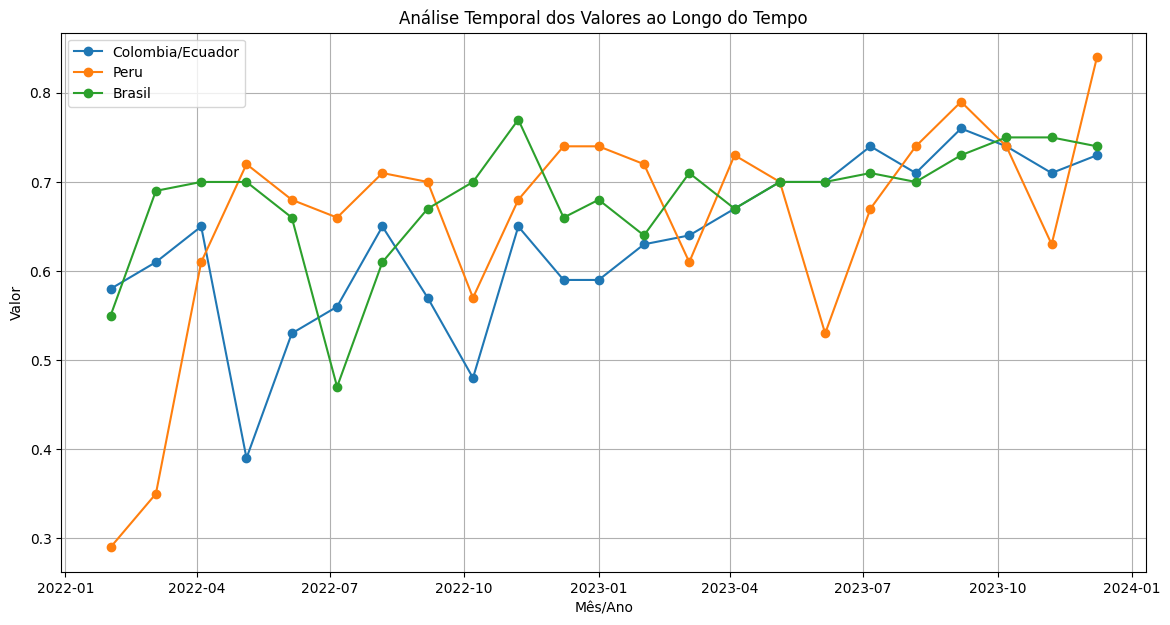

In [7]:
colombia_ecuador = df[df['Country'] == 'Colombia/Ecuador']
peru = df[df['Country'] == 'Peru']
brasil = df[df['Country'] == 'Brasil']

# Plotando a análise temporal
plt.figure(figsize=(14, 7))

# Linha para Colombia/Ecuador
plt.plot(colombia_ecuador['Month/Year'], colombia_ecuador['Value'], label='Colombia/Ecuador', marker='o')

# Linha para Peru
plt.plot(peru['Month/Year'], peru['Value'], label='Peru', marker='o')

# Linha para Brasil
plt.plot(brasil['Month/Year'], brasil['Value'], label='Brasil', marker='o')

# Adicionando títulos e rótulos
plt.title('Análise Temporal dos Valores ao Longo do Tempo')
plt.xlabel('Mês/Ano')
plt.ylabel('Valor')
plt.legend()

# Exibindo o gráfico
plt.grid(True)
plt.show()

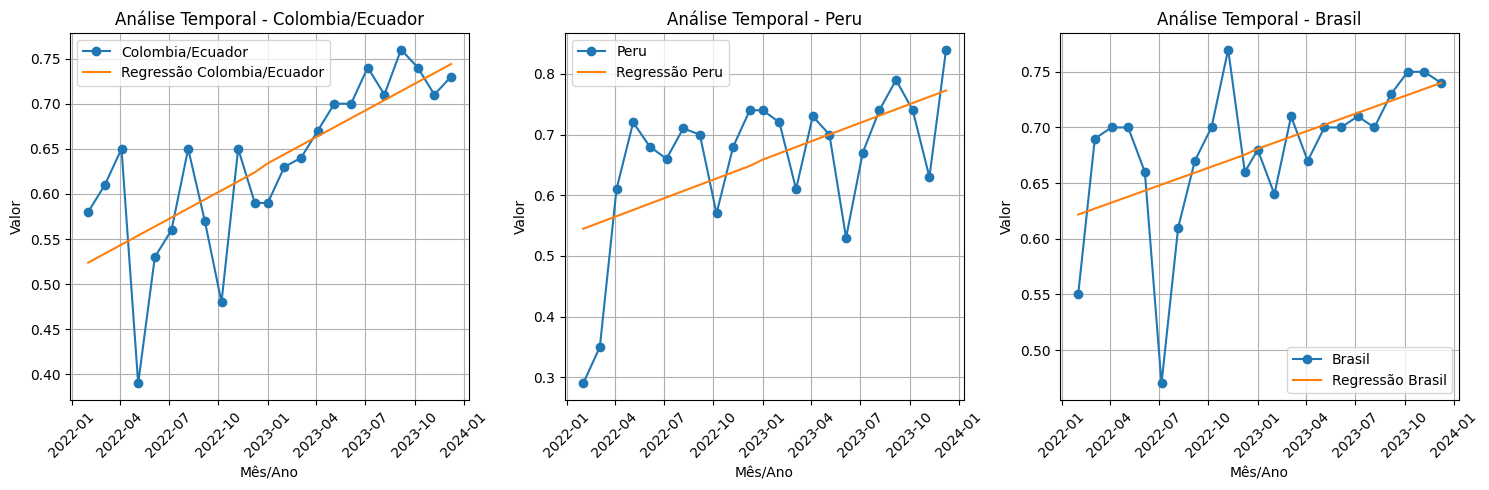

In [8]:
import statsmodels.api as sm

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for i, (country, data) in enumerate(zip(['Colombia/Ecuador', 'Peru', 'Brasil'],
                                      [colombia_ecuador, peru, brasil])):
    # Ajustando o modelo de regressão linear
    X = sm.add_constant(data.index.values)
    y = data['Value']
    model = sm.OLS(y, X).fit()

    # Plotando os dados e a reta de regressão em cada subplot
    axes[i].plot(data['Month/Year'], data['Value'], label=country, marker='o')
    axes[i].plot(data['Month/Year'], model.fittedvalues, label=f'Regressão {country}')
    axes[i].set_title(f'Análise Temporal - {country}')
    axes[i].set_xlabel('Mês/Ano')
    axes[i].set_ylabel('Valor')
    axes[i].legend()
    axes[i].grid(True)

    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Os gráficos fornecem uma visão geral da evolução de um determinado valor ao longo do tempo para três países: Colômbia/Equador, Peru e Brasil. Vamos analisar cada um deles:

Estrutura dos Gráficos
 * Eixo X: Representa o tempo, dividido em meses e anos.
 * Eixo Y: Representa o valor numérico da variável analisada.

Linhas:
 * Vermelha: Representa a variação do valor ao longo do tempo para cada país.
 * Dourada: Representa a linha de regressão linear, que indica a tendência geral dos dados.

Interpretação dos Gráficos
1. Colômbia/Equador:

 * Tendência: Apresenta uma tendência de crescimento ao longo do período analisado, com algumas flutuações. A linha de regressão confirma essa tendência positiva.
 * Variabilidade: Os valores apresentam uma certa variabilidade, com picos e vales ao longo do tempo.
2. Peru:

 * Tendência: Também mostra uma tendência de crescimento, porém com um padrão mais irregular. A linha de regressão indica um crescimento mais moderado em comparação com a Colômbia/Equador.
 * Variabilidade: Apresenta uma variabilidade maior, com oscilações mais acentuadas.
3. Brasil:

 * Tendência: A tendência é menos clara, com períodos de crescimento e queda. A linha de regressão indica um crescimento leve, mas com menos consistência que os outros países.
 * Variabilidade: A variabilidade é alta, com picos e vales pronunciados.

Insights Gerais
 * Tendências de Crescimento: Os três países apresentam, de forma geral, uma tendência de crescimento ao longo do período analisado, embora com diferentes intensidades.
 * Variabilidade: A variabilidade dos dados é alta em todos os países, indicando a presença de fatores que influenciam o valor de forma significativa ao longo do tempo.

 * Diferentes Padrões: Cada país apresenta um padrão de crescimento e variabilidade distinto, sugerindo que fatores específicos influenciam cada economia de forma particular.

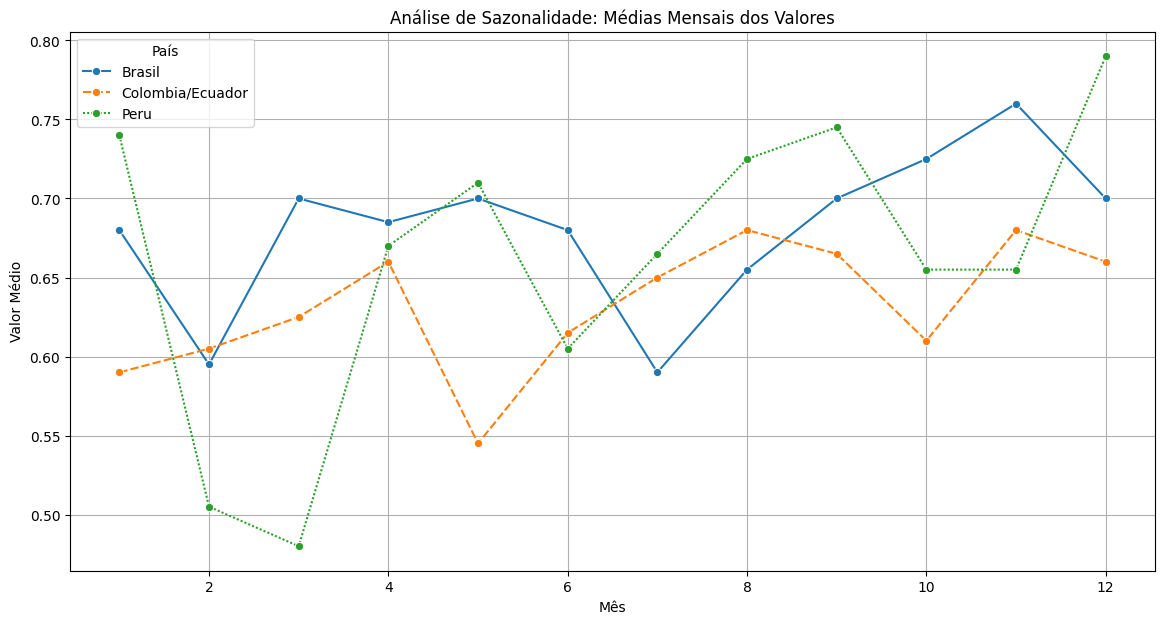

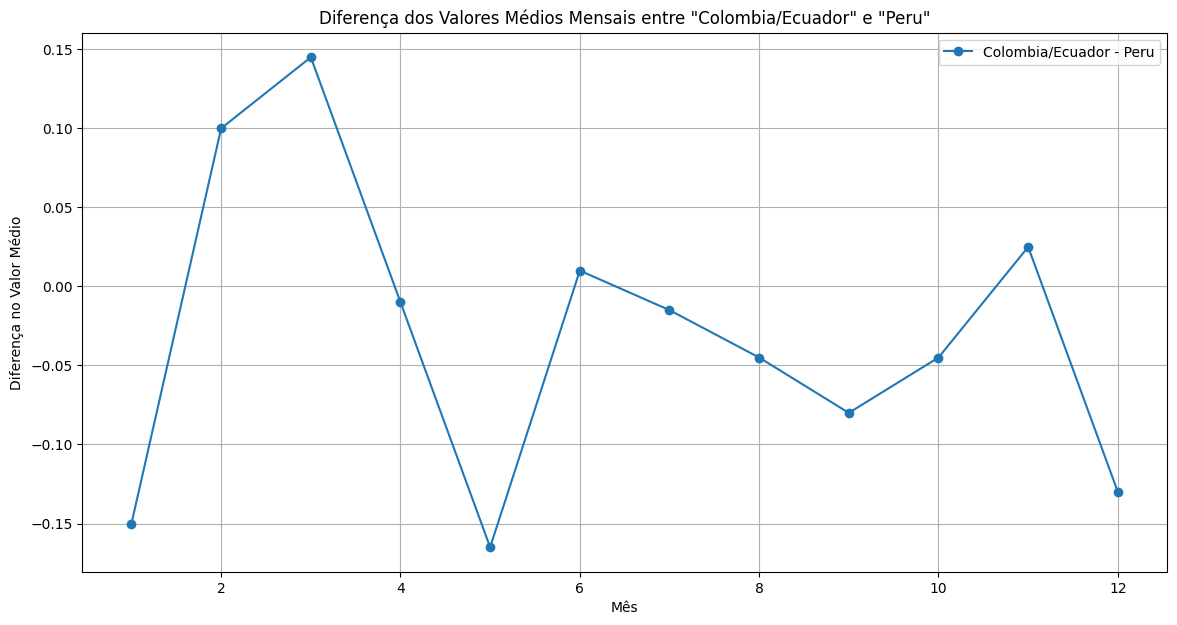

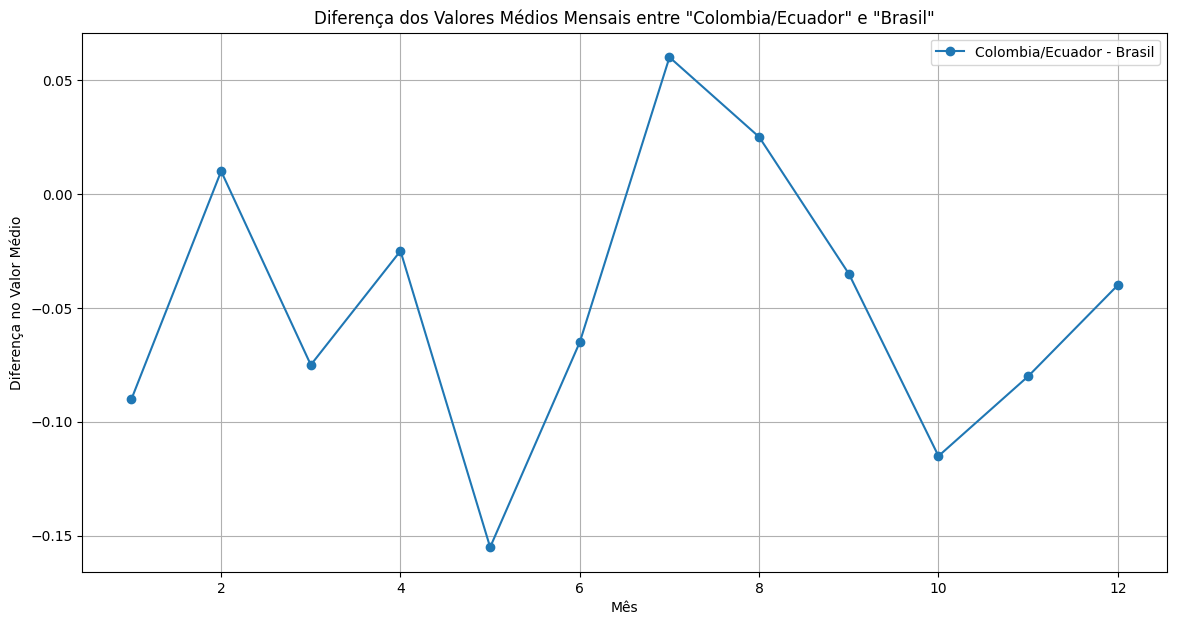

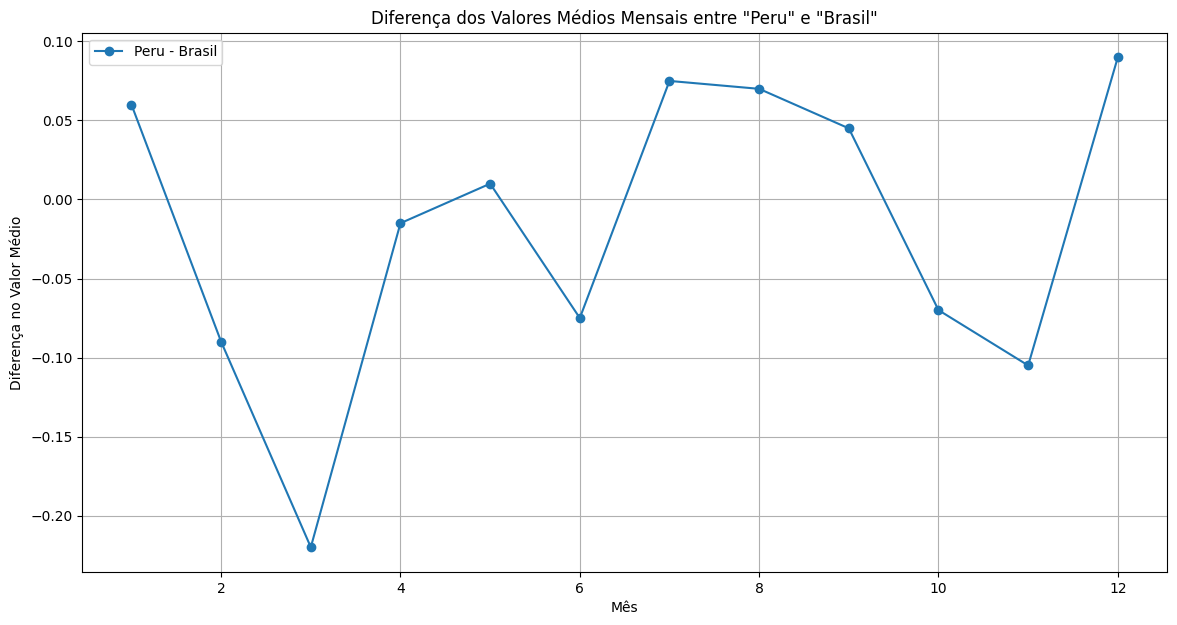

In [9]:
def analisar_sazonalidade(df, paises, titulo_principal):
  """
  Calcula as médias mensais para os países especificados e plota os resultados.

  Args:
    df: DataFrame com os dados.
    paises: Lista com os nomes dos países a serem comparados.
    titulo_principal: Título do gráfico principal.
  """

  # Extraindo o mês
  df['Month'] = df['Month/Year'].dt.month

  # Calculando a média por mês para cada país
  monthly_means = df.groupby(['Month', 'Country'])['Value'].mean().unstack()

  # Plotando a sazonalidade
  plt.figure(figsize=(14, 7))
  sns.lineplot(data=monthly_means, marker='o')  # Utilizando seaborn para paleta de cores
  plt.title(titulo_principal)
  plt.xlabel('Mês')
  plt.ylabel('Valor Médio')
  plt.legend(title='País')
  plt.grid(True)
  plt.show()

  # Comparando os valores entre os países para cada mês
  for i in range(len(paises) - 1):
    for j in range(i+1, len(paises)):
      pais1 = paises[i]
      pais2 = paises[j]
      diferenca = monthly_means[pais1] - monthly_means[pais2]
      plt.figure(figsize=(14, 7))
      plt.plot(diferenca, marker='o', label=f'{pais1} - {pais2}')
      plt.title(f'Diferença dos Valores Médios Mensais entre "{pais1}" e "{pais2}"')
      plt.xlabel('Mês')
      plt.ylabel('Diferença no Valor Médio')
      plt.legend()
      plt.grid(True)
      plt.show()

# Exemplo de uso
paises = ['Colombia/Ecuador', 'Peru', 'Brasil']
analisar_sazonalidade(df, paises, 'Análise de Sazonalidade: Médias Mensais dos Valores')

Aqui podemos identificar e visualizar padrões sazonais nos dados de diferentes países, comparando as médias mensais de um determinado valor.

O gráfico apresenta as médias mensais de um determinado valor para três países: Brasil, Colômbia/Equador e Peru. A linha do tempo se estende de janeiro a dezembro, evidenciando a variação desses valores ao longo do ano.

Principais Observações:

 * Sazonalidade: Há uma clara indicação de sazonalidade nos dados, ou seja, os valores médios tendem a se repetir em padrões semelhantes ao longo dos meses do ano.
 * Diferenças entre Países: Os três países apresentam padrões sazonais distintos, com picos e vales ocorrendo em meses diferentes.
 * Variação ao Longo do Ano: A amplitude da variação sazonal também difere entre os países.

Insights Mais Específicos

Para uma análise mais detalhada, podemos observar os seguintes pontos:

 * Brasil: Apresenta um padrão mais suave, com uma leve tendência de crescimento ao longo do ano e um pico mais pronunciado em um determinado mês (que não está explicitado no gráfico).
 * Colômbia/Equador: Apresenta uma maior variabilidade, com picos e vales mais acentuados. A tendência geral parece ser de crescimento, com um pico mais evidente em um determinado mês.
 * Peru: Apresenta um padrão mais irregular, com picos e vales distribuídos de forma menos uniforme ao longo do ano.

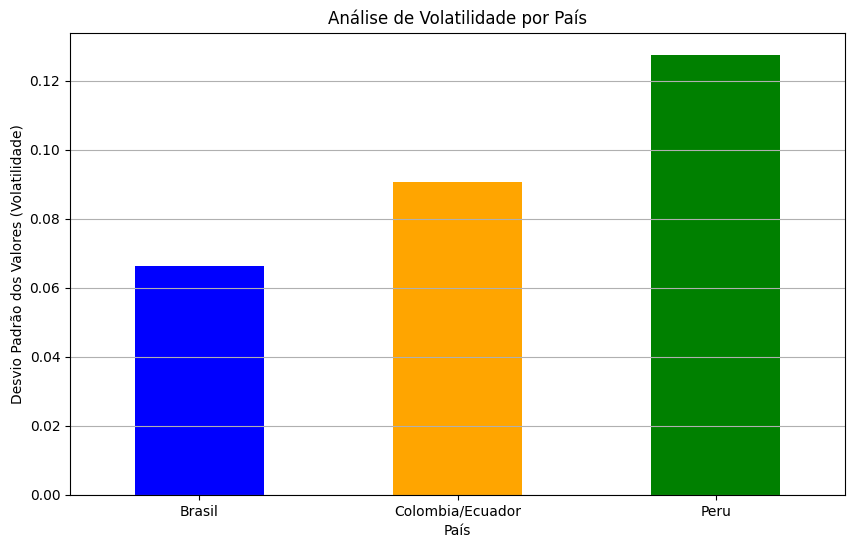

In [10]:
# Calculando a volatilidade (desvio padrão) por país
volatility = df.groupby('Country')['Value'].std()

# Plotando a volatilidade
plt.figure(figsize=(10, 6))
volatility.plot(kind='bar', color=['blue', 'orange', 'green'])

# Adicionando títulos e rótulos
plt.title('Análise de Volatilidade por País')
plt.xlabel('País')
plt.ylabel('Desvio Padrão dos Valores (Volatilidade)')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

Cálculo da Volatilidade:

Acima fizemos o codigo que grupa os dados por país e calcula o desvio padrão do valor para cada grupo. O desvio padrão é uma medida estatística que quantifica a dispersão dos dados em relação à média, sendo comumente utilizado como um indicador de volatilidade.

O gráfico de barras apresenta a volatilidade de um determinado valor para três países: Brasil, Colômbia/Equador e Peru. A altura de cada barra representa o desvio padrão dos valores, ou seja, quanto maior a barra, maior a volatilidade.

Insights que podem ser extraídos:

 * Nível de Volatilidade: O gráfico permite comparar diretamente o nível de volatilidade entre os três países. O país com a barra mais alta apresenta a maior volatilidade, indicando que os valores nesse país variam mais ao longo do tempo em comparação aos outros.
 * Comparação entre Países: Ao comparar as alturas das barras, podemos identificar quais países apresentam maior ou menor estabilidade nos valores.
 * Identificação de Risco: A volatilidade é frequentemente associada ao risco. Um alto nível de volatilidade indica maior incerteza e, consequentemente, maior risco para investimentos ou outras atividades relacionadas aos valores em questão.

Exemplo de Interpretação:

Se o valor medido for o preço de uma ação, um país com alta volatilidade indica que o preço da ação nesse país flutua bastante ao longo do tempo, o que pode representar tanto oportunidades de lucro quanto de perda para os investidores.

Essa análise de volatilidade pode ser útil em diversas áreas, como:

 * Investimentos: Ajudar investidores a identificar ativos mais ou menos arriscados.
 * Gestão de riscos: Auxiliar empresas a entender e mitigar os riscos associados a suas operações em diferentes países.
 * Análise de mercado: Comparar a volatilidade de diferentes mercados e identificar oportunidades de investimento.
 * Política econômica: Avaliar a estabilidade econômica de diferentes países e identificar possíveis riscos sistêmicos.


A volatilidade é apenas um dos indicadores que podem ser utilizados para avaliar o risco. Outros indicadores, como a correlação entre diferentes ativos, também podem fornecer informações importantes.

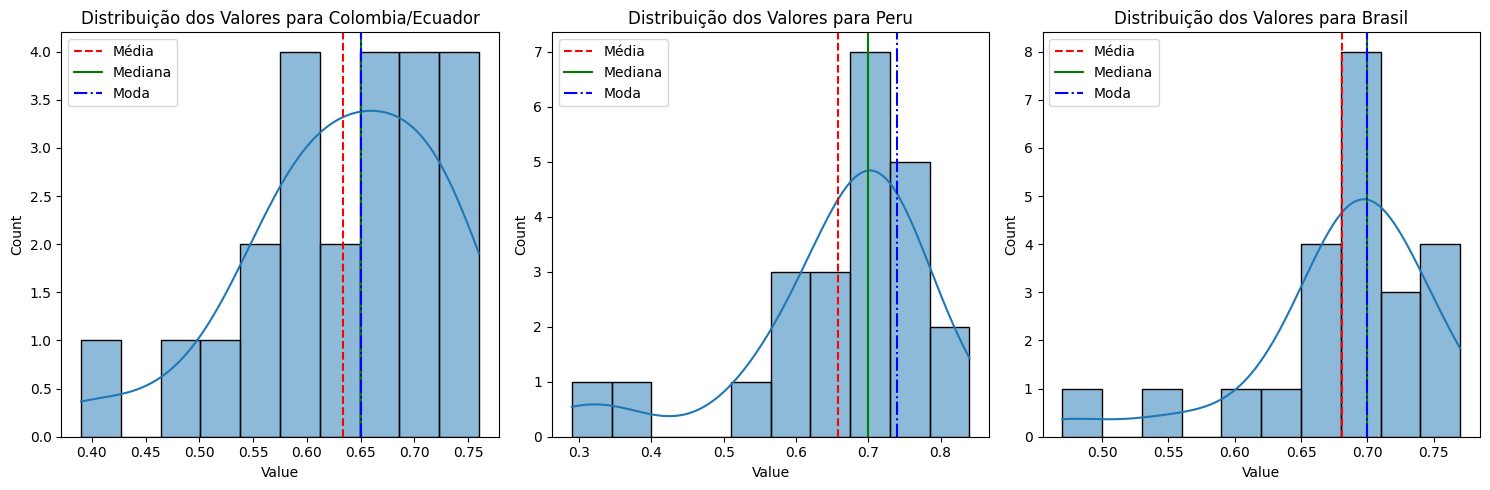

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Definindo uma paleta de cores
sns.set_palette("husl")

# Plotando os histogramas em cada subplot e calculando as medidas estatísticas
for i, country in enumerate(df['Country'].unique()):
    subset = df[df['Country'] == country]
    sns.histplot(data=subset, x='Value', bins=10, ax=axes[i], kde=True)

    # Calculando as medidas estatísticas
    mean = subset['Value'].mean()
    median = subset['Value'].median()
    mode = subset['Value'].mode()[0]  # Retorna o primeiro valor da moda

    # Adicionando as medidas estatísticas ao gráfico
    axes[i].axvline(mean, color='r', linestyle='--', label='Média')
    axes[i].axvline(median, color='g', linestyle='-', label='Mediana')
    axes[i].axvline(mode, color='b', linestyle='-.', label='Moda')

    axes[i].set_title(f'Distribuição dos Valores para {country}')
    axes[i].legend()

plt.tight_layout()
plt.show()

Os três gráficos mostram a distribuição dos valores de metas de venda (Value) para os países "Colombia/Ecuador", "Peru" e "Brasil". Em cada gráfico, há uma linha indicando a média, mediana e moda da distribuição, permitindo uma análise comparativa dessas estatísticas descritivas.

* Distribuição para Colombia/Ecuador:

 * Média: Representada pela linha vermelha pontilhada, a média está ligeiramente à direita da mediana e da moda, sugerindo uma leve inclinação positiva na distribuição.
 * Mediana: A linha verde sólida, que está próxima ao centro da distribuição.
 * Moda: A linha azul pontilhada está sobre a mediana, indicando que os valores mais frequentes estão centralizados em torno desse ponto.
 * Interpretação: A distribuição é assimétrica à direita (positivamente inclinada), com a maioria dos valores concentrados entre 0.60 e 0.70.

* Distribuição para Peru:

 * Média: A linha vermelha está à esquerda da mediana e da moda, sugerindo uma distribuição assimétrica à esquerda (negativamente inclinada).
 * Mediana: A linha verde está ligeiramente à direita da média.
 * Moda: A linha azul pontilhada coincide com a mediana, indicando que a maioria dos valores se concentra nesse ponto.
 * Interpretação: A distribuição apresenta uma leve inclinação à esquerda, com a maioria dos valores concentrados em torno de 0.65 a 0.70.

* Distribuição para Brasil:

 * Média: A linha vermelha está bem próxima da mediana e da moda, indicando uma distribuição quase simétrica.
 * Mediana: A linha verde e a linha azul pontilhada (moda) estão praticamente sobrepostas, sugerindo que os valores mais comuns estão centralizados.
 * oda: Coincide com a mediana, reforçando a simetria na distribuição.
 * Interpretação: A distribuição é aproximadamente simétrica, com a maioria dos valores concentrados entre 0.65 e 0.70.

Conclusão Geral:

Colombia/Ecuador tem uma distribuição levemente inclinada à direita, indicando uma predominância de valores mais baixos em comparação aos outros países.
Peru apresenta uma leve inclinação à esquerda, indicando a presença de alguns valores mais baixos que puxam a média para a esquerda.
Brasil exibe uma distribuição quase simétrica, sugerindo uma estabilidade maior nos valores das metas ao longo do tempo.
Essas análises podem ajudar a entender como os valores de metas de venda se distribuem em diferentes países e identificar padrões que possam influenciar nas previsões futuras.

## Matriz Correlação


A matriz de correlação no gráfico de heatmap mostra a relação entre as variáveis numéricas presentes no conjunto de dados. Cada célula da matriz exibe o coeficiente de correlação entre dois pares de variáveis, variando de -1 (correlação negativa perfeita) a 1 (correlação positiva perfeita). A cor das células ajuda a visualizar a força e a direção dessas correlações: tons de vermelho indicam correlação positiva, enquanto tons de azul indicam correlação negativa.

In [12]:
df['Year'] = df['Month/Year'].dt.year
df['Month'] = df['Month/Year'].dt.month
df['DayOfYear'] = df['Month/Year'].dt.dayofyear

# Calculando a matriz de correlação
correlation_matrix = df[['Value', 'Year', 'Month', 'DayOfYear']].corr()

# Exibindo a matriz de correlação
print(correlation_matrix)

              Value      Year     Month  DayOfYear
Value      1.000000  0.462057  0.326917   0.326917
Year       0.462057  1.000000 -0.075094  -0.075094
Month      0.326917 -0.075094  1.000000   1.000000
DayOfYear  0.326917 -0.075094  1.000000   1.000000


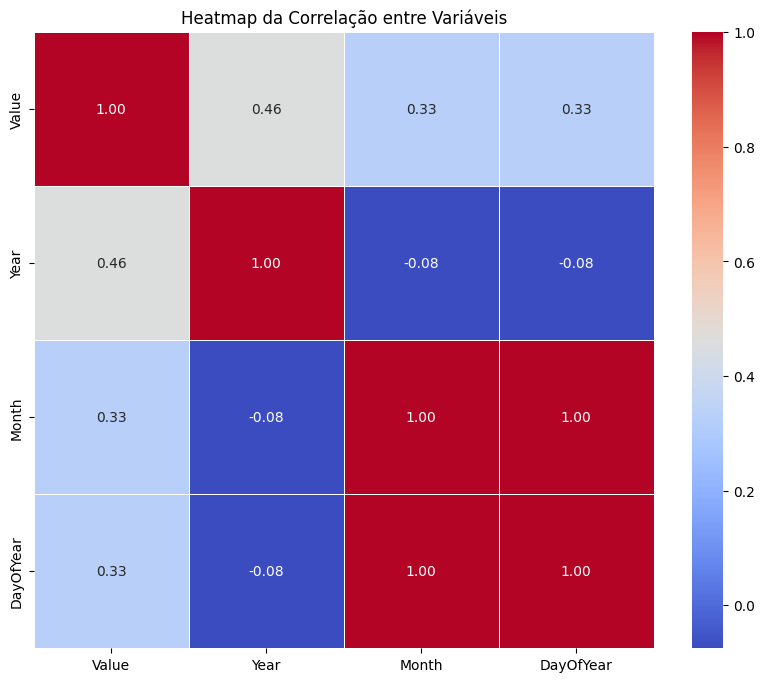

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# Adicionando título
plt.title('Heatmap da Correlação entre Variáveis')
plt.show()

### Explicação das Correlações:

Value (Valor de Meta de Vendas):

* Correlação com Year (Ano): Há uma correlação moderada positiva (0.46), sugerindo que os valores de metas de vendas tendem a aumentar ou se comportar de forma consistente ao longo dos anos.
* Correlação com Month (Mês) e DayOfYear (Dia do Ano): Ambas as correlações são positivas (0.33), mas mais fracas em comparação com o ano, indicando que as metas de vendas também podem ter uma variação mensal ou sazonal, mas essa relação é menos significativa.

Year (Ano):

* Correlação com Month (Mês) e DayOfYear (Dia do Ano): Ambas as correlações são praticamente nulas (-0.08), indicando que o ano não tem uma relação significativa com o mês ou o dia do ano, o que é esperado, já que essas variáveis são independentes em relação ao ano.

* Month (Mês) e DayOfYear (Dia do Ano):

* A correlação entre Month e DayOfYear é perfeita (1.00), pois o número do mês e o dia do ano estão diretamente relacionados.

Conclusão Geral:

* A variável Value (valor da meta de vendas) tem uma correlação moderada com o Year (ano), sugerindo que as metas de vendas podem ter mudado ou crescido ao longo dos anos.
* A relação com Month e DayOfYear é mais fraca, indicando que, apesar de haver alguma sazonalidade, essa relação não é tão forte.
* A relação entre Month e DayOfYear é direta e perfeita, o que é esperado, já que ambos estão diretamente relacionados ao calendário.


In [14]:
df_encoded = pd.get_dummies(df, columns=['Country'], drop_first=False)

# Calculando a correlação
correlation_matrix = df_encoded.corr()

# Exibindo a matriz de correlação como uma tabela formatada
print("Matriz de Correlação:")
print(tabulate(correlation_matrix, headers='keys', tablefmt='heavy_grid'))

# Se você quiser apenas a correlação entre 'Value' e as colunas de países
correlation_value_countries = correlation_matrix['Value']

# Exibindo a correlação entre 'Value' e as colunas de países como uma tabela formatada
print("\nCorrelação entre 'Value' e as colunas de países:")
print(tabulate(correlation_value_countries.reset_index(), headers=['Variable', 'Correlation'], tablefmt='heavy_grid'))

Matriz de Correlação:
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃                          ┃   Month/Year ┃       Value ┃        Month ┃         Year ┃    DayOfYear ┃   Country_Brasil ┃   Country_Colombia/Ecuador ┃   Country_Peru ┃
┣━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃ Month/Year               ┃  1           ┃  0.582168   ┃  0.441315    ┃  0.861679    ┃  0.441315    ┃     -1.31085e-14 ┃                8.31401e-15 ┃    4.81208e-15 ┃
┣━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━┫
┃ Value                    ┃  0.582168    ┃  1          ┃  0.326917    ┃  0.462057    ┃  0.326917    ┃      0.166532    ┃               -0

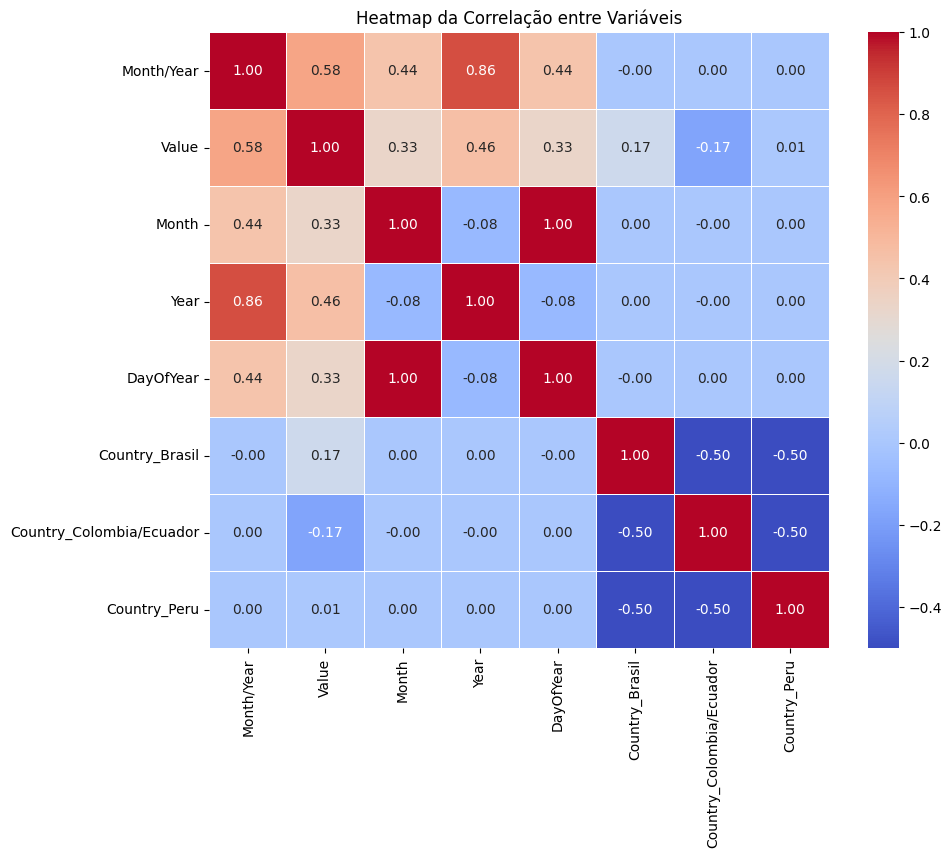

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

# Adicionando título
plt.title('Heatmap da Correlação entre Variáveis')
plt.show()

Essa matriz de correlação mostra a relação entre as variáveis temporais e as variáveis categóricas associadas aos países (Brasil, Peru, e Colômbia/Ecuador) com o valor das metas de vendas (Value). Aqui está a análise detalhada:

### Principais Relações:
* Month/Year (Mês/Ano):

 * Correlação com Value (0.58): Existe uma correlação moderada entre o tempo e o valor das metas de vendas, o que sugere que, com o passar do tempo, os valores de metas têm uma tendência de crescimento ou variação previsível.
 * Correlação com Year (0.86): Uma forte correlação positiva com o ano é esperada, uma vez que "Mês/Ano" é uma variável temporal.
 * Correlação com Month (0.44): Correlação moderada, o que pode indicar variações sazonais nas metas de vendas ao longo dos meses.

* Value (Valor de Metas):

 * Correlação com Year (0.46): Correlação moderada, sugerindo que as metas aumentam ou variam com o tempo.
 * Correlação com Month (0.33) e DayOfYear (0.33): Essas correlações, embora fracas, podem indicar algum efeito sazonal ou variação de curto prazo nas metas de vendas.
 * Correlação com Country_Brasil (0.17): Correlação fraca, indicando que os valores de metas do Brasil não têm uma relação muito forte com o tempo.
 * Correlação negativa com Country_Colombia/Ecuador (-0.17): A correlação negativa sugere que, conforme as metas de vendas de Colômbia/Ecuador variam, os valores das metas têm uma leve tendência oposta.

* Month (Mês) e DayOfYear (Dia do Ano):

 * Essas variáveis possuem correlação perfeita entre si (1.00), o que faz sentido, pois ambas representam dimensões temporais.

* Year (Ano):

 * Correlação com Month/Year (0.86): Forte correlação positiva, como esperado, já que "Mês/Ano" é parcialmente derivado do ano.
 * Correlação fraca com as outras variáveis temporais e categóricas.

* Correlação entre os Países:

 * Country_Brasil, Country_Colombia/Ecuador e Country_Peru: A correlação entre esses grupos de países é perfeitamente negativa (-0.50), indicando que a variável categórica usada para representar o país está sendo corretamente codificada de maneira mútua. Se o valor para "Brasil" é 1, "Colombia/Ecuador" e "Peru" são 0, e vice-versa, o que explica a correlação negativa.

**Conclusões**:

* Valores das metas de vendas mostram uma correlação moderada com o tempo (Month/Year e Year), sugerindo que essas metas podem estar mudando de acordo com o ano.
* Variação sazonal pode existir, mas a correlação com os meses e dias do ano não é muito forte.
* Países têm um impacto diferenciado nos valores de metas. Por exemplo, o Brasil tem uma correlação ligeiramente positiva com os valores, enquanto Colômbia/Ecuador apresenta uma correlação negativa.

## Conclusões gerais EDA (Exploratory Data Analisys).


A análise exploratória de dados realizada forneceu insights valiosos sobre o comportamento dos valores de metas de vendas ao longo do tempo para os países analisados: Brasil, Peru e Colômbia/Ecuador.

1. Distribuição dos Valores: A análise da distribuição dos valores revelou que cada país possui características distintas em relação à média, mediana e moda dos valores. Por exemplo, o Brasil apresentou uma distribuição concentrada em torno de valores mais elevados, enquanto a Colômbia/Ecuador mostrou uma maior variabilidade com uma moda ligeiramente mais baixa. Essas diferenças sugerem que os fatores que influenciam o desempenho de vendas podem variar significativamente entre os países, possivelmente devido a variações regionais ou econômicas.

2. Correlação entre Variáveis: A matriz de correlação mostrou que o fator temporal (Month/Year) possui uma correlação positiva moderada com os valores de metas de vendas, especialmente com o ano (Year). Essa relação sugere que as metas de vendas tendem a variar ao longo do tempo, refletindo possivelmente tendências sazonais ou mudanças estratégicas. Além disso, as variáveis dos países (Brasil, Peru, Colômbia/Ecuador) apresentaram correlações fracas com os valores de vendas, indicando que as diferenças nas metas de vendas entre os países não são tão pronunciadas quanto as variações ao longo do tempo.

3. Impacto Temporal: O fator tempo, especialmente o ano, demonstrou ser um dos principais indicadores de variação nas metas de vendas. A correlação positiva entre Year e Value reforça a importância de considerar o contexto temporal nas análises e previsões futuras. Essa observação sugere que mudanças ao longo dos anos, como variações econômicas, políticas ou de mercado, podem ter influenciado as metas estabelecidas para os países analisados.

4. Considerações sobre os Países: As análises específicas por país não mostraram correlações fortes entre os países e os valores das metas, sugerindo que outros fatores, além da localização geográfica, podem ser mais determinantes no desempenho das vendas. No entanto, as diferenças na distribuição dos valores entre os países indicam que, apesar das correlações fracas, o contexto regional ainda desempenha algum papel, que poderia ser explorado em análises mais detalhadas ou estudos futuros.

Próximos Passos
Com base na EDA, podemos agora avançar para a fase de modelagem, onde as tendências temporais identificadas serão levadas em consideração para construir modelos preditivos robustos que possam prever os valores de metas de vendas para o próximo período. A atenção às características específicas de cada país e a incorporação de fatores temporais serão cruciais para melhorar a acurácia das previsões.